In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [2]:
pip install statsmodels


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U kaleido


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv('api.csv', encoding='utf-8')

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/1942488875.py:1: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('api.csv', encoding='utf-8')


In [5]:
df

,api_spec_id,commit_date,info_version,id,label,dom_label,diff2,errors,count,content,...,Security_modified,Security_added,Security_deleted,Endpoints_modified,repo_name,owner,commits,info_versions_changes,api_age,growth_classification
0,96.0,2020-10-06,0.1.0,218.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,community-calendar,stephenhoward,20,0.0,NaN,NaN
1,96.0,2020-10-07,0.1.0,217.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,mcmm-yaml,hboutemy,16,0.0,NaN,NaN
2,96.0,2020-10-07,0.1.0,216.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,mcmm-yaml,hboutemy,11,0.0,NaN,NaN
3,96.0,2020-10-07,0.1.0,215.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,openapi-directory,ltmert,11,1.0,NaN,NaN
4,96.0,2020-10-07,0.1.0,214.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,1,0,0.0,mcmm-yaml,hboutemy,22,0.0,1183.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74579,242156.0,2019-04-21,2016-11-28,664014.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,openapi-directory-lite,darosh,2,0.0,NaN,NaN
74580,242156.0,2019-04-30,2016-11-28,664013.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,corpus,ogen-go,4,0.0,NaN,NaN
74581,242156.0,2019-06-07,2016-11-28,664012.0,Empty,Empty,Backward compatibility errors (5):\nerror at s...,compatibility errors,5.0,request-parameter-became-required,...,0.0,0,0,6.0,WellwardEventGrid,dongravlinnordic,4,0.0,NaN,NaN
74582,242156.0,2019-06-14,2016-11-28,664011.0,Empty,Empty,{},NaN,NaN,NaN,...,0.0,0,0,0.0,mineranker,francisypl,14,0.0,NaN,NaN


In [6]:
allowed_labels = ['major', 'minor', 'patch']
labels = df[df['label'].isin(allowed_labels)]
labels.fillna(0, inplace=True)

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/26112486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.fillna(0, inplace=True)


In [7]:
# Model Training on cleaned Data
scaler = StandardScaler()

# Get columns to use
cols_to_use = labels[['Endpoints_added', 'Endpoints_deleted','Components_parameters_added', 'Paths_added', 'Paths_deleted', 'Components_Schemas_Added', 'Components_Schemas_Deleted', 'Info_description_changes', 'Paths_modified', 'Endpoints_modified']].columns

data_scaled = scaler.fit_transform(labels[cols_to_use])

# Define the model
model = GaussianMixture(n_components=3, random_state=32, max_iter=200, init_params='random', covariance_type='full', n_init=1, warm_start=True)

# Fit the model
model.fit(data_scaled)

# Get the cluster labels
cluster_labels = model.predict(data_scaled)

# Map the cluster labels to major, minor, and patch labels
label_map = {0: "major", 1: "minor", 2: "patch"}
predicted_labels = [label_map[label] for label in cluster_labels]

# Add the major, minor, and patch labels to the dataframe
labels["predicted_labels"] = predicted_labels

# Accuracy
print("Accuracy: ", accuracy_score(labels["label"], labels["predicted_labels"]))
print("Precision: ", precision_score(labels["label"], labels["predicted_labels"], average='weighted'))
# Classification report
print(classification_report(labels["label"], labels["predicted_labels"]))



Accuracy:  0.1514453288646837
Precision:  0.5783696999482134
              precision    recall  f1-score   support

       major       0.04      0.73      0.08       222
       minor       0.27      0.13      0.18      1014
       patch       0.70      0.12      0.21      3538

    accuracy                           0.15      4774
   macro avg       0.34      0.33      0.16      4774
weighted avg       0.58      0.15      0.19      4774



/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/2154401288.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["predicted_labels"] = predicted_labels


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4774 entries, 39 to 73895
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   api_spec_id                           4774 non-null   float64
 1   commit_date                           4774 non-null   object 
 2   info_version                          4774 non-null   object 
 3   id                                    4774 non-null   float64
 4   label                                 4774 non-null   object 
 5   dom_label                             4774 non-null   object 
 6   diff2                                 4774 non-null   object 
 7   errors                                4774 non-null   object 
 8   count                                 4774 non-null   float64
 9   content                               4774 non-null   object 
 10  Year                                  4774 non-null   int64  
 11  type_of_change      

#### PCA on Cleaned Data

In [9]:
from sklearn.decomposition import PCA


X = labels.loc[:, "externalDocs.added":"Endpoints_modified"]
y = labels['label']

# data scaling
x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
 
pca_features = pca.fit_transform(x_scaled)
 
print('Shape before PCA: ', x_scaled.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

Shape before PCA:  (4774, 40)
Shape after PCA:  (4774, 2)


In [10]:
# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_
 
# Feature names before PCA
feature_names = X.columns

 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

# Print the resulting loadings_df
loadings_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


,PC1,PC2
feature_names,,
externalDocs.added,0.044034,0.112782
externalDocs.deleted,0.005206,0.001479
Info_contact_name_changes,0.003324,0.075387
Servers_modified,-0.005109,-0.007814
Endpoints_added,0.413378,-0.048503
Endpoints_deleted,0.479495,-0.134255
Components_parameters_added,0.082224,0.094533
Servers_added,0.064878,-0.000301
Servers_deleted,0.074014,-0.010636


In [11]:
# Merge the principal components with the original dataframe
pca_df = pd.concat([pca_df, labels[['label','predicted_labels','Year']]], axis=1)




In [12]:
# Set correlation threshold
threshold = 0.01

# Filter loadings_df based on threshold
loadings_df_high_corr = loadings_df[loadings_df.abs() > threshold]

# Drop rows with all NaN values
loadings_df_high_corr = loadings_df_high_corr.dropna()

In [13]:
import plotly.graph_objs as go
import numpy as np

# Get the loadings of x and y axes
xs = loadings_df_high_corr['PC1']
ys = loadings_df_high_corr['PC2']

# Create a scatterplot of the loadings with vectors
fig = go.Figure(data=[go.Scatter(
    x=xs,
    y=ys,
    mode='markers',
    marker=dict(
        size=12,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='spectral', # one of plotly colorscales
        showscale=False
    )
)])
for i in range(len(xs)):
 fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=xs[i],
        y1=ys[i],
        line=dict(
            color="black",
            width=0.4
        )
    )
for i in range(len(xs)):
    fig.add_annotation(
        x=xs[i],
        y=ys[i],
        text=loadings_df_high_corr.index[i],
        showarrow=False
    )

fig.update_layout(template='ggplot2', title='PCA Loadings on Entire Cleaned Dataset ', width=1400, height=1000, showlegend=False,xaxis_title='PC1', yaxis_title='PC2')


### PCA on Young and Old API's

In [16]:
api_specs=pd.read_csv('api_specs.csv', encoding='utf-8')

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/289446102.py:1: DtypeWarning:

Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.



In [17]:
loadings_df

,PC1,PC2
feature_names,,
externalDocs.added,0.044034,0.112782
externalDocs.deleted,0.005206,0.001479
Info_contact_name_changes,0.003324,0.075387
Servers_modified,-0.005109,-0.007814
Endpoints_added,0.413378,-0.048503
Endpoints_deleted,0.479495,-0.134255
Components_parameters_added,0.082224,0.094533
Servers_added,0.064878,-0.000301
Servers_deleted,0.074014,-0.010636


In [18]:
young_api= api_specs[api_specs['API_group'] == 'young']
old_api= api_specs[api_specs['API_group'] == 'old']

In [19]:
young_api.fillna(0, inplace=True)
old_api.fillna(0, inplace=True)

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/201050396.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/201050396.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
young_api.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6781 entries, 0 to 8488
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   commit_date                           6781 non-null   object 
 1   info_version                          6781 non-null   object 
 2   id_x                                  6781 non-null   float64
 3   api_spec_id                           6781 non-null   float64
 4   label                                 6781 non-null   object 
 5   externalDocs.added                    6781 non-null   object 
 6   externalDocs.deleted                  6781 non-null   object 
 7   Info_contact_name_changes             6781 non-null   int64  
 8   Servers_modified                      6781 non-null   float64
 9   Endpoints_added                       6781 non-null   int64  
 10  Endpoints_deleted                     6781 non-null   int64  
 11  Components_parameters_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.



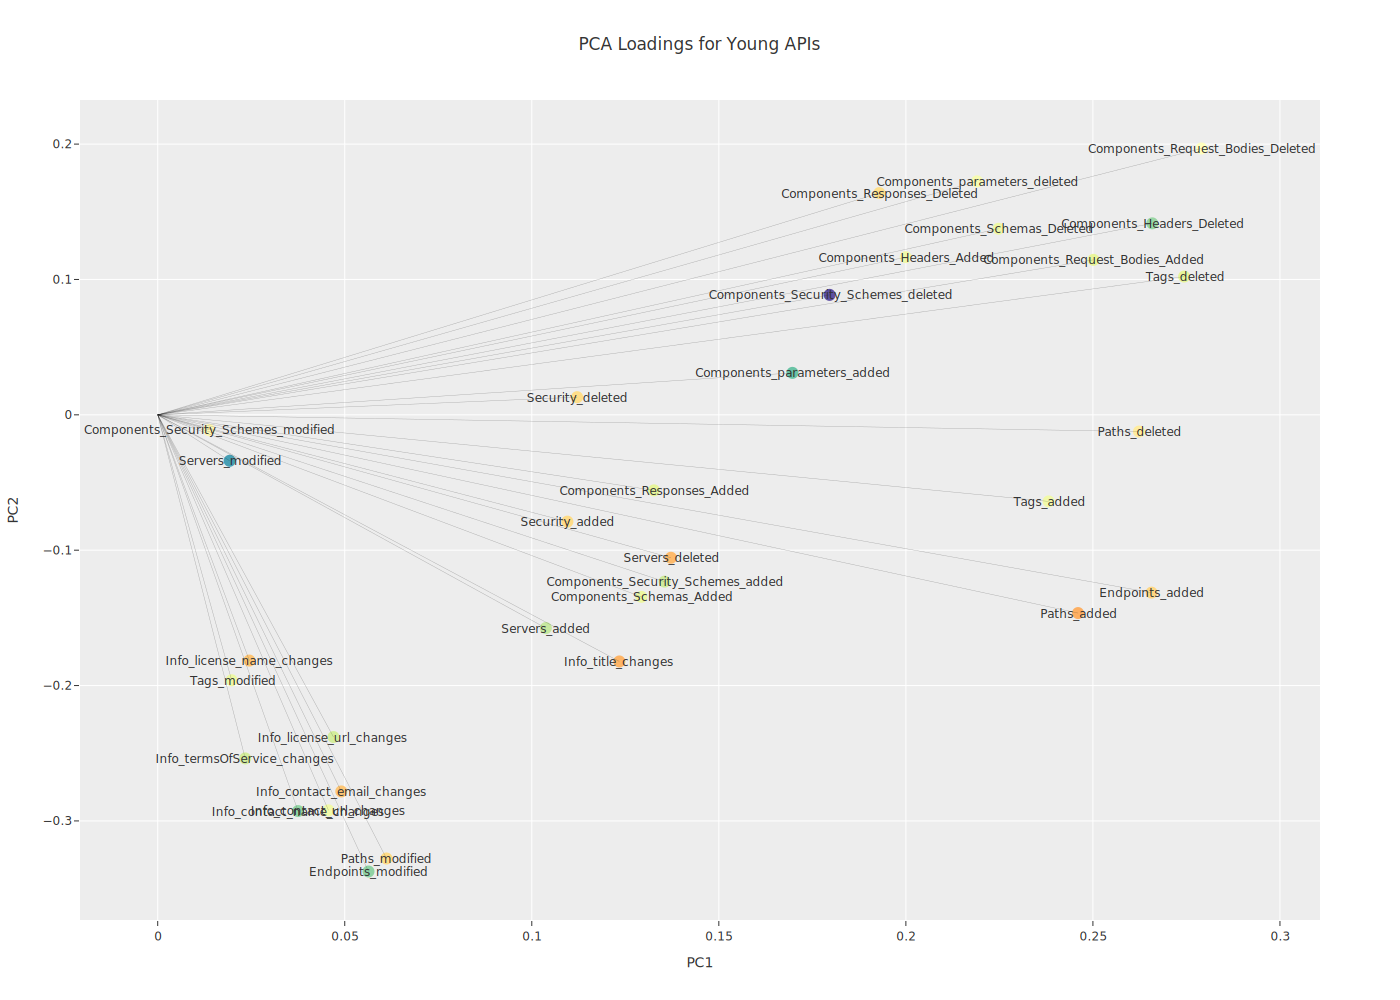

In [22]:
from sklearn.decomposition import PCA


X = young_api.loc[:, "Info_contact_name_changes":"Endpoints_modified"]
y = young_api['label']

# data scaling
x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
 
pca_features = pca.fit_transform(x_scaled)

# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_
 
# Feature names before PCA
feature_names = X.columns
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

# Set correlation threshold
threshold = 0.01

# Filter loadings_df based on threshold
loadings_df_high_corr = loadings_df[loadings_df.abs() > threshold]

# Drop rows with all NaN values
loadings_df_high_corr = loadings_df_high_corr.dropna()

import plotly.graph_objs as go
import numpy as np

# Get the loadings of x and y axes
xs = loadings_df_high_corr['PC1']
ys = loadings_df_high_corr['PC2']

# Create a scatterplot of the loadings with vectors
fig = go.Figure(data=[go.Scatter(
    x=xs,
    y=ys,
    mode='markers',
    marker=dict(
        size=12,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='spectral', # one of plotly colorscales
        showscale=False
    )
)])
for i in range(len(xs)):
 fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=xs[i],
        y1=ys[i],
        line=dict(
            color="black",
            width=0.4
        )
    )
for i in range(len(xs)):
    fig.add_annotation(
        x=xs[i],
        y=ys[i],
        text=loadings_df_high_corr.index[i],
        showarrow=False
    )

fig.update_layout(template='ggplot2', title='PCA Loadings for Young APIs', width=1400, height=1000, showlegend=False,xaxis_title='PC1', yaxis_title='PC2')

fig.show("svg")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.



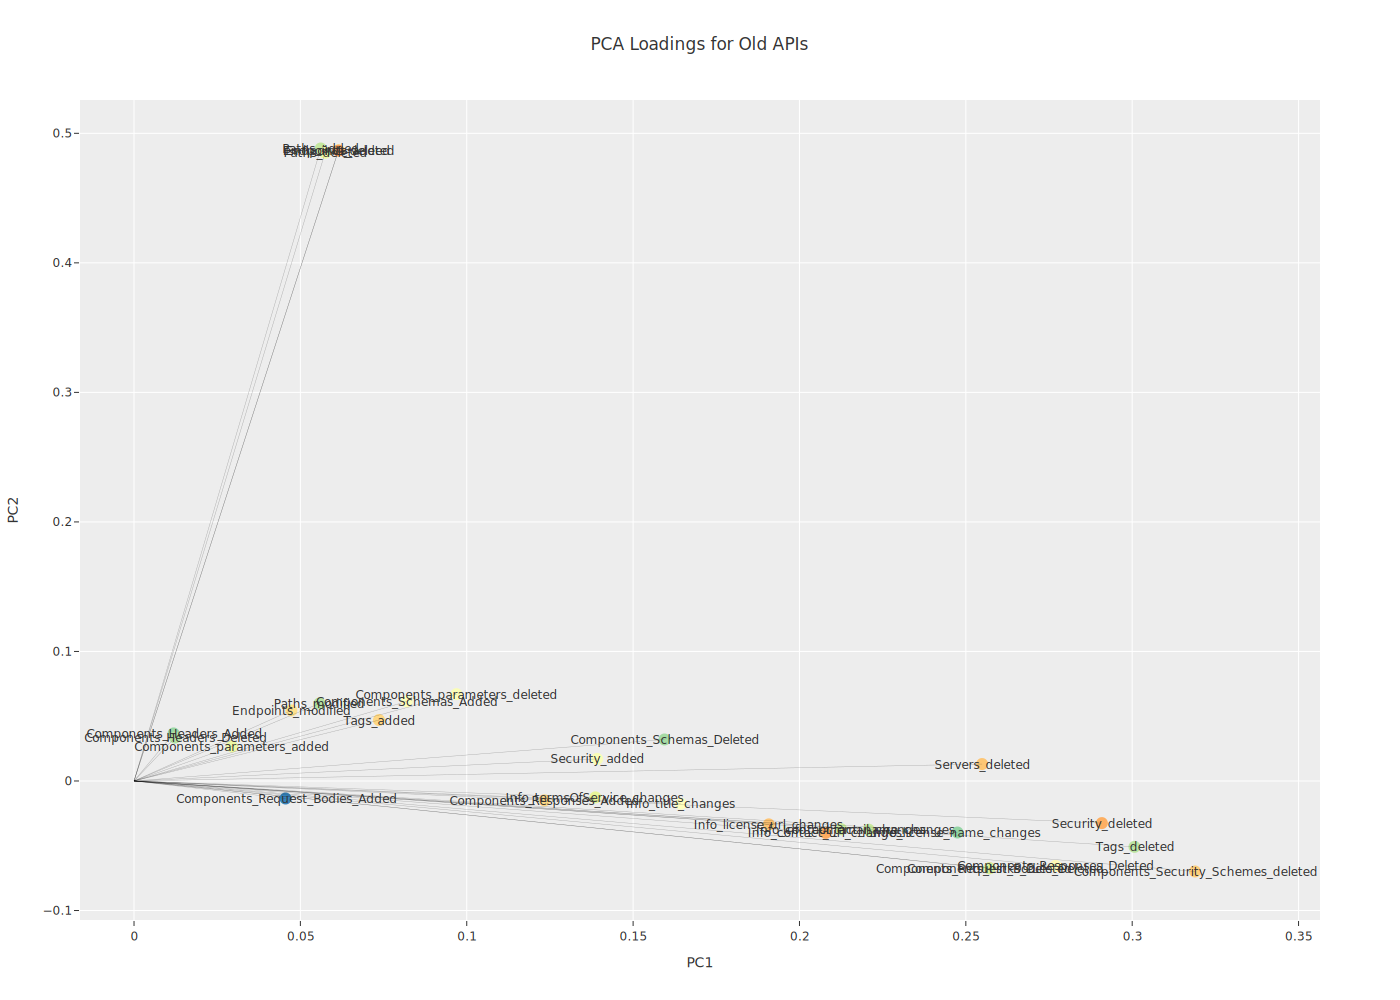

In [24]:
from sklearn.decomposition import PCA


X = old_api.loc[:, "Info_contact_name_changes":"Endpoints_modified"]
y = old_api['label']

# data scaling
x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
 
pca_features = pca.fit_transform(x_scaled)

# Principal components correlation coefficients
loadings = pca.components_
 
# Number of features before PCA
n_features = pca.n_features_
 
# Feature names before PCA
feature_names = X.columns
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

# Set correlation threshold
threshold = 0.01

# Filter loadings_df based on threshold
loadings_df_high_corr = loadings_df[loadings_df.abs() > threshold]

# Drop rows with all NaN values
loadings_df_high_corr = loadings_df_high_corr.dropna()

import plotly.graph_objs as go
import numpy as np

# Get the loadings of x and y axes
xs = loadings_df_high_corr['PC1']
ys = loadings_df_high_corr['PC2']

# Create a scatterplot of the loadings with vectors
fig = go.Figure(data=[go.Scatter(
    x=xs,
    y=ys,
    mode='markers',
    marker=dict(
        size=12,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='spectral', # one of plotly colorscales
        showscale=False
    )
)])
for i in range(len(xs)):
 fig.add_shape(
        type="line",
        x0=0,
        y0=0,
        x1=xs[i],
        y1=ys[i],
        line=dict(
            color="black",
            width=0.4
        )
    )
for i in range(len(xs)):
    fig.add_annotation(
        x=xs[i],
        y=ys[i],
        text=loadings_df_high_corr.index[i],
        showarrow=False
    )

fig.update_layout(template='ggplot2', title='PCA Loadings for Old APIs', width=1400, height=1000, showlegend=False,xaxis_title='PC1', yaxis_title='PC2')

fig.show("svg")

### PCA on all nine subsets of predicted and true labels

In [25]:
# Split into dataframes based on label and predicted label
major_patch = labels[(labels['label'] == 'major') & (labels['predicted_labels'] == 'patch')]
major_minor = labels[(labels['label'] == 'major') & (labels['predicted_labels'] == 'minor')]
major_major = labels[(labels['label'] == 'major') & (labels['predicted_labels'] == 'major')]

minor_patch = labels[(labels['label'] == 'minor') & (labels['predicted_labels'] == 'patch')]
minor_minor = labels[(labels['label'] == 'minor') & (labels['predicted_labels'] == 'minor')]
minor_major = labels[(labels['label'] == 'minor') & (labels['predicted_labels'] == 'major')]


patch_patch = labels[(labels['label'] == 'patch') & (labels['predicted_labels'] == 'patch')]
patch_minor = labels[(labels['label'] == 'patch') & (labels['predicted_labels'] == 'minor')]
patch_major = labels[(labels['label'] == 'patch') & (labels['predicted_labels'] == 'major')]


In [26]:
from sklearn.datasets import load_wine
import pandas as pd

# Load dataset
data = load_wine()
X = labels.loc[:, "externalDocs.added":"Endpoints_modified"]
y = labels['label']
label_imp = X.columns
# Make dataframe
df = pd.DataFrame(data=X, columns=label_imp, index=y)

df.to_csv('dff.csv')

In [27]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

X =labels[['Endpoints_modified', 'Endpoints_added', 'Endpoints_deleted', 'Paths_added','Paths_deleted','Paths_modified']]
x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)

pca_features = pca.fit_transform(x_scaled)
loadings = pca.components_
n_features = pca.n_features_in_

feature_names = X.columns

pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df = loadings_df[(loadings_df.T != 0).any()]

threshold = 0.01
loadings_df_high_corr = loadings_df[loadings_df.abs() > threshold]

loadings_df_high_corr = loadings_df_high_corr.dropna()

xs = loadings_df_high_corr['PC1']
ys = loadings_df_high_corr['PC2']

labels[['PC1', 'PC2']] = pd.DataFrame(pca_features)


/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/1289569556.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_7135/1289569556.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


dfs = {
    'major_patch': major_patch,
    'major_minor': major_minor,
    'major_major': major_major,
    'minor_patch': minor_patch,
    'minor_minor': minor_minor,
    'minor_major': minor_major,
    'patch_patch': patch_patch,
    'patch_minor': patch_minor,
    'patch_major': patch_major
}

for df in dfs:
 def plot_pca(df, title):
    X = df[['Endpoints_modified', 'Endpoints_added', 'Endpoints_deleted', 'Paths_added','Paths_deleted','Paths_modified']]
    y = df['label']

    # data scaling
    x_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)

    pca_features = pca.fit_transform(x_scaled)

    # Principal components correlation coefficients
    loadings = pca.components_

    # Number of features before PCA
    n_features = pca.n_features_in_

    # Feature names before PCA
    feature_names = X.columns

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')

    # Remove feature names with zero correlation coefficient
    loadings_df = loadings_df[(loadings_df.T != 0).any()]

    # Set correlation threshold
    threshold = 0.01

    # Filter loadings_df based on threshold
    loadings_df_high_corr = loadings_df[loadings_df.abs() > threshold]

    # Drop rows with all NaN values
    loadings_df_high_corr = loadings_df_high_corr.dropna()

    # Get the loadings of x and y axes
    xs = loadings_df_high_corr['PC1']
    ys = loadings_df_high_corr['PC2']

    # Create a scatterplot of the loadings with vectors
    fig = go.Figure(data=[go.Scatter(
        x=xs,
        y=ys,
        mode='markers',
        marker=dict(
            size=12,
            color=np.random.randn(500), #set color equal to a variable
            colorscale='spectral', # one of plotly colorscales
            showscale=False
        )
    )])

    # Add arrows to the scatterplot
    for i in range(len(xs)):
        fig.add_shape(
            type="line",
            x0=0,
            y0=0,
            x1=xs[i],
            y1=ys[i],
            line=dict(
                color="black",
                width=0.4
            )
        )

    # Add text labels to the scatterplot
    for i in range(len(xs)):
        fig.add_annotation(
            x=xs[i],
            y=ys[i],
            text=loadings_df_high_corr.index[i],
            showarrow=False,
            align='center',
            yanchor='auto',
            yshift=10
            )
            

    fig.update_layout(template='ggplot2', title=title, width=1000, height=600, showlegend=False,xaxis_title='PC1', yaxis_title='PC2')

    fig.show("svg")


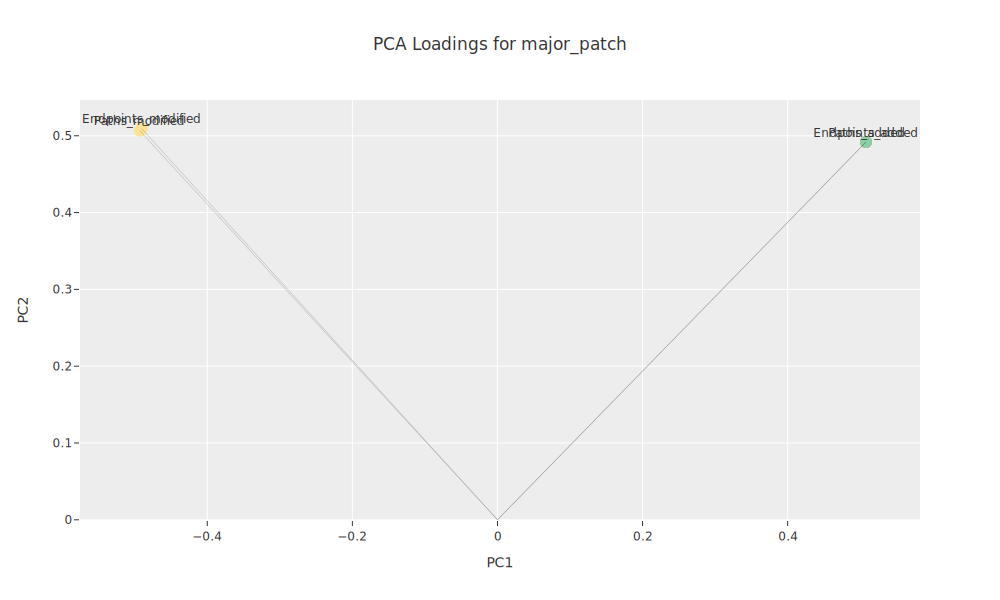

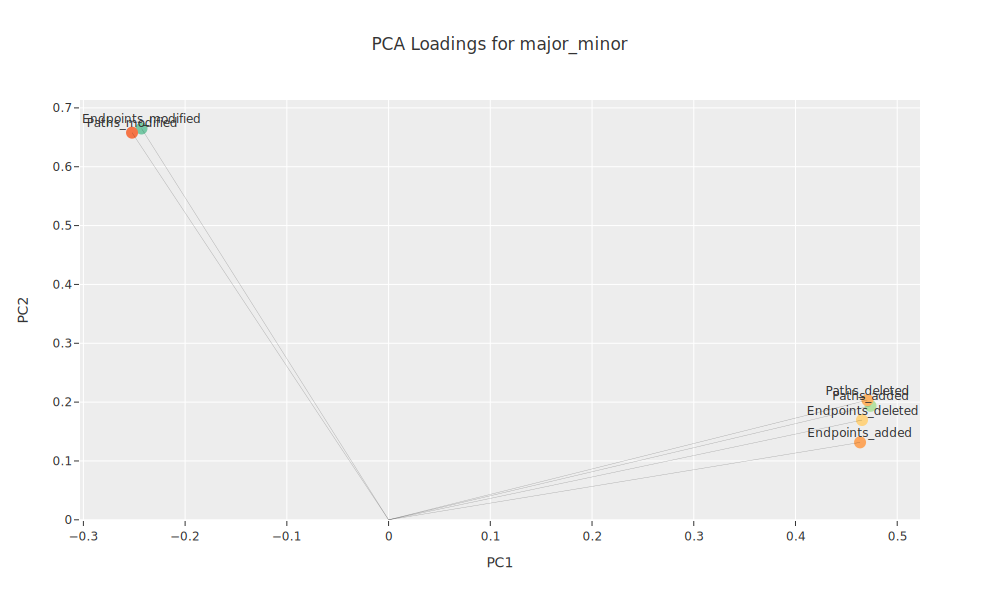

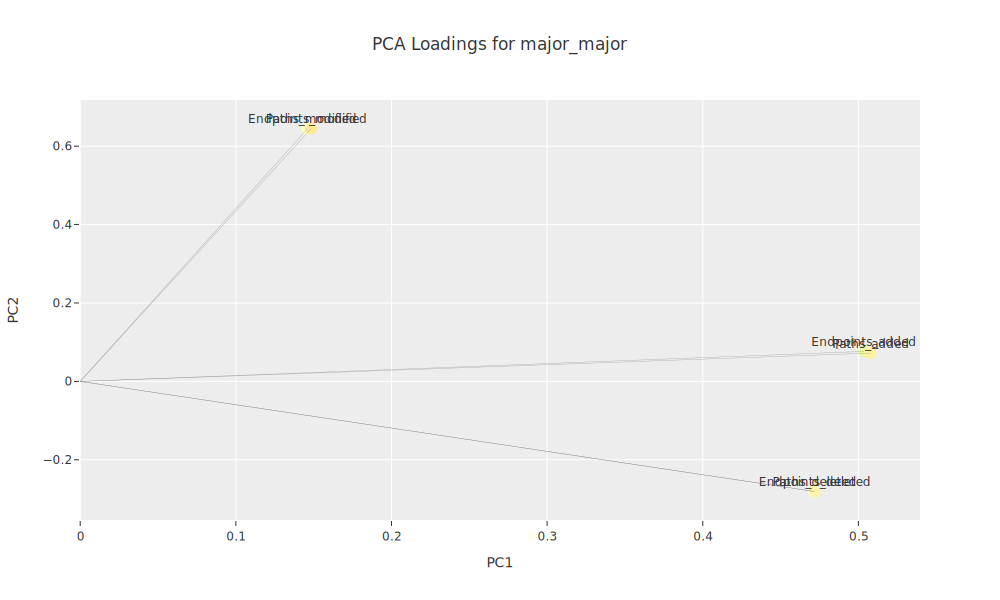

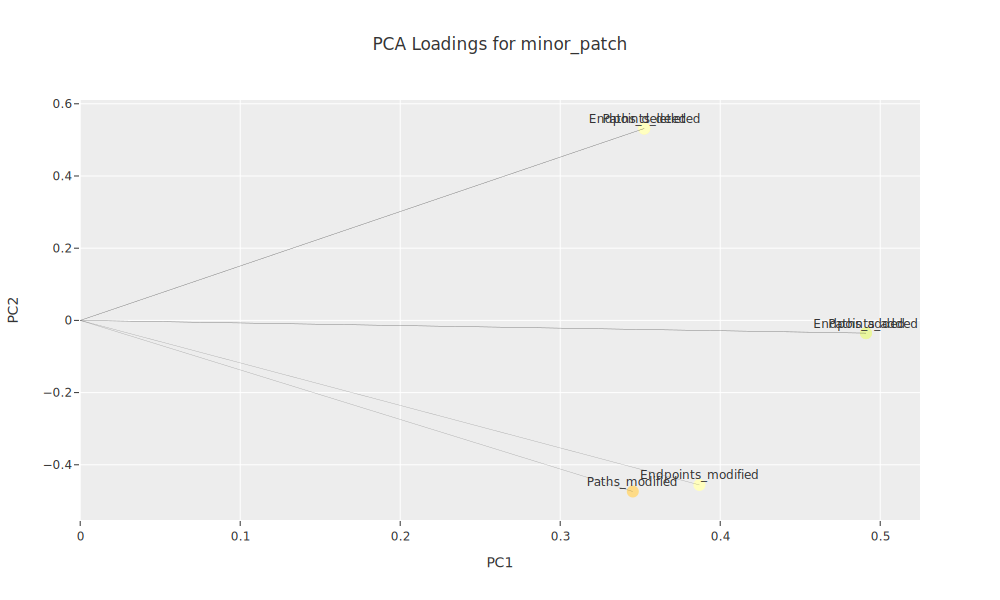

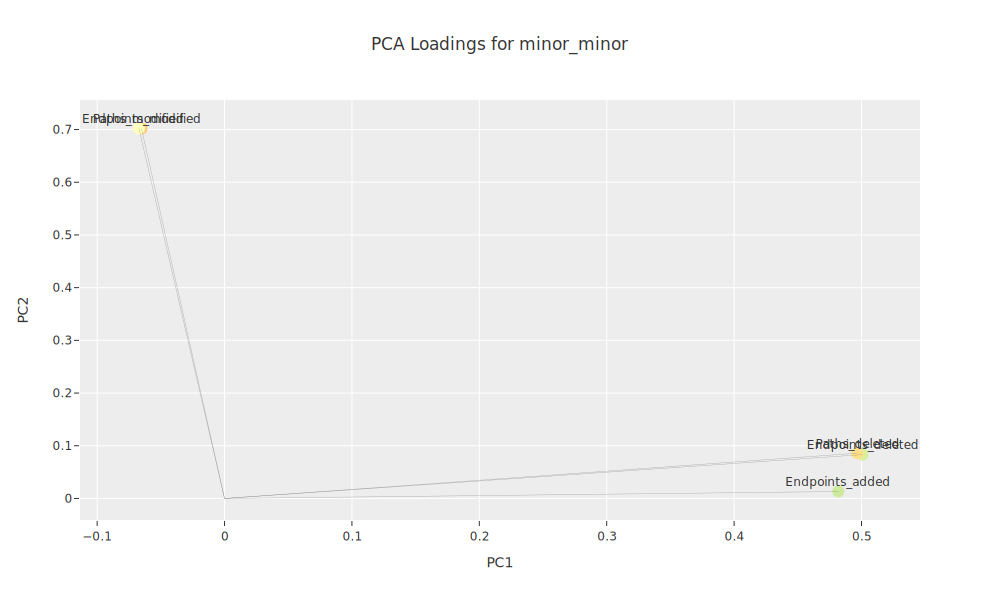

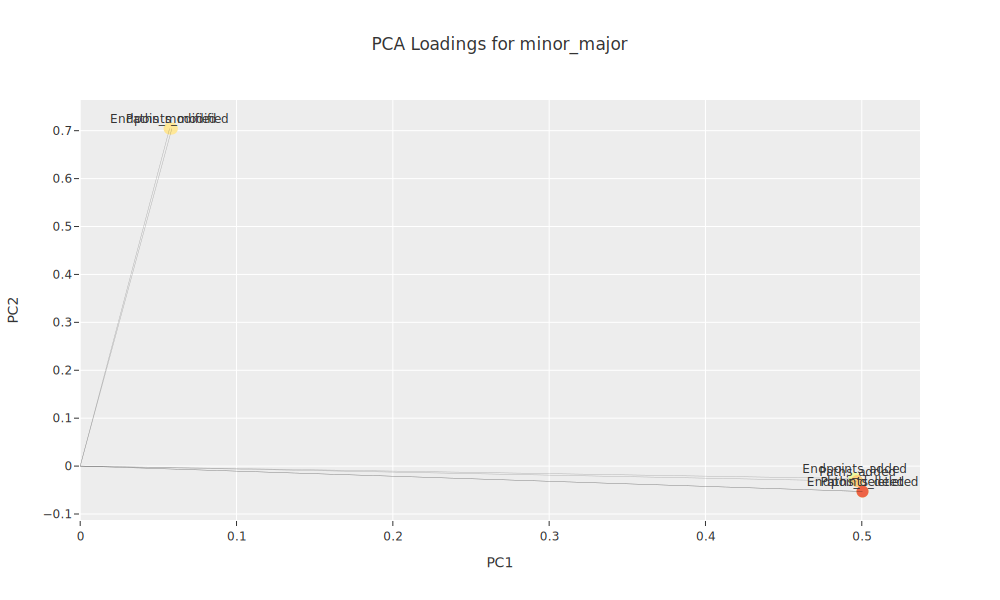

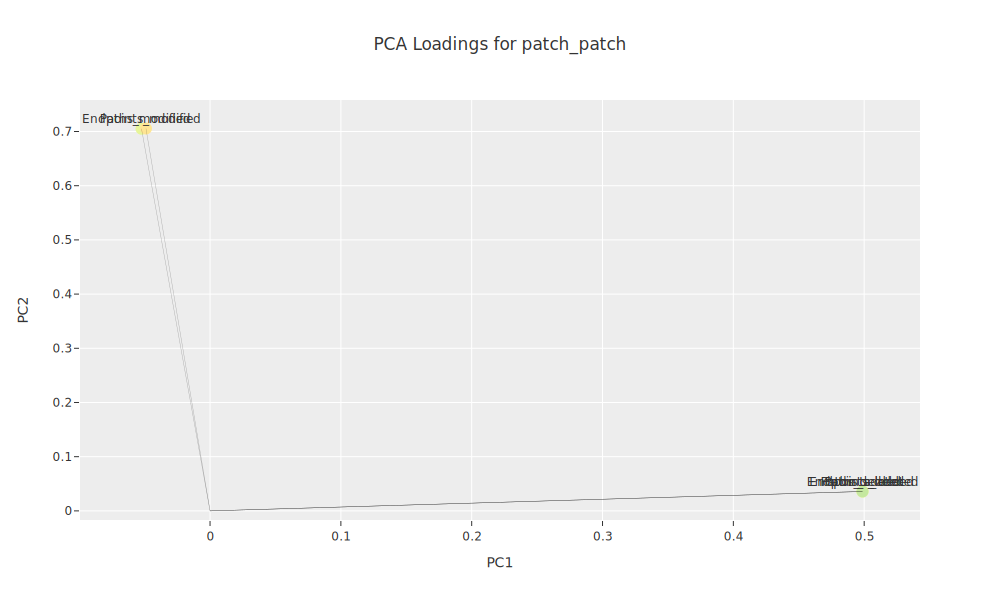

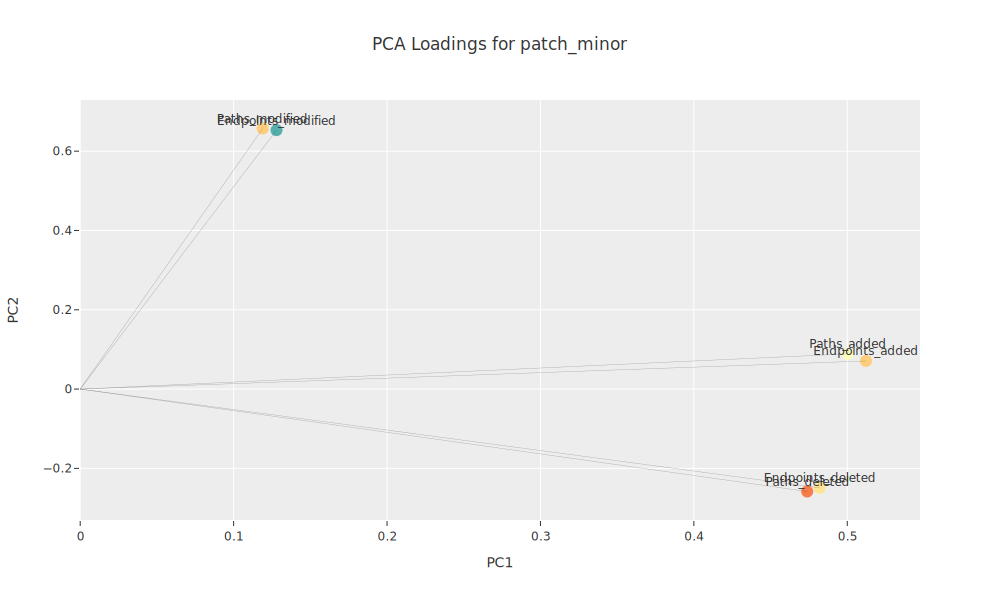

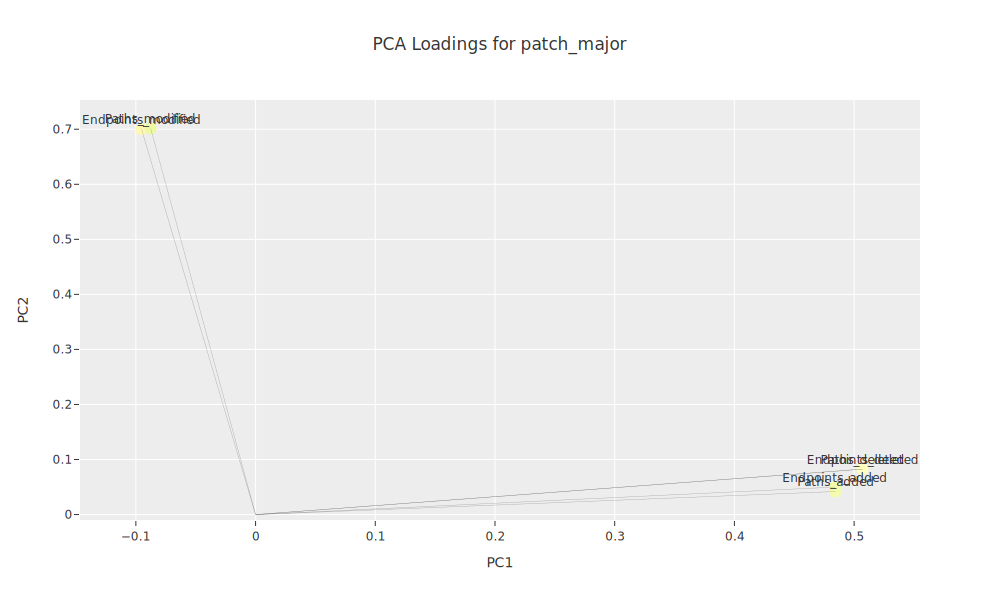

In [29]:
for name, df in dfs.items():
    title = f'PCA Loadings for {name}'
    plot_pca(df, title)